In [1]:
import h5py
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# Temperature for the two consecutive timestamp
temperature_fields_input = []
temperature_fields_output = []

# Folder Path
path = "solutions"
  
# Read text File  
def read_text_file(file_path):
    with h5py.File(file_path, 'r') as f:
        temperature_fields_input.append(f['temperature'][:][:-1])
        temperature_fields_output.append(f['temperature'][:][1:])
        
        
# Iterate through all file
for file in os.listdir(path):
    file_path = f"{path}/{file}"
  
    # call read text file function
    read_text_file(file_path)
    #print(f"{file_path} is finished reading")

temperature_fields_input = np.asarray(temperature_fields_input).reshape(9900,201,401)
temperature_fields_output = np.asarray(temperature_fields_output).reshape(9900,201,401)

In [3]:
print(temperature_fields_input[1])
print(temperature_fields_output[0])
print(len(temperature_fields_input))

[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.99502265 0.9950206  0.99502635 ... 0.9951441  0.99513966 0.99513716]
 [0.990008   0.9900054  0.99001276 ... 0.9901801  0.99017423 0.99017096]
 ...
 [0.00999234 0.00999044 0.00999579 ... 0.01074193 0.01072025 0.01070789]
 [0.00500912 0.00500767 0.00501178 ... 0.0055766  0.00555991 0.00555046]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.99502265 0.9950206  0.99502635 ... 0.9951441  0.99513966 0.99513716]
 [0.990008   0.9900054  0.99001276 ... 0.9901801  0.99017423 0.99017096]
 ...
 [0.00999234 0.00999044 0.00999579 ... 0.01074193 0.01072025 0.01070789]
 [0.00500912 0.00500767 0.00501178 ... 0.0055766  0.00555991 0.00555046]
 [0.         0.         0.         ... 0.         0.         0.        ]]
9900


In [4]:
#Parameters
n_epoch = 200
batch_size = 16
lr = 5e-5
betas = (0.9, 0.999)

accurate_loss_baseline = 0.0005

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print("Current device is ",device)

# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device is  cpu


In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential( # 1x201x401 => 6x23x45
            nn.Conv2d(1, 3, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
            nn.Conv2d(3, 6, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
        )
        
    def forward(self, x):
        out=self.encoder(x)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential( # 6x23x45 => 201x401
            nn.ConvTranspose2d(6, 3, stride=(3, 3), kernel_size=(5, 5), padding=(2,2)),
            nn.Tanh(),
            nn.ConvTranspose2d(3, 1, stride=(3, 3), kernel_size=(5, 5), padding=(1,0)),
        )
        

    def forward(self, x):
        out=self.decoder(x)
        return out

In [7]:
encoder_path = "2D_ConvAE_results/Conv2D_encoder_best_Gadi.pth"
decoder_path = "2D_ConvAE_results/Conv2D_decoder_best_Gadi.pth"

encoder = Encoder().to(device)
decoder = Decoder().to(device)
encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device('cpu')))

print("Encoder and Decoder loaded!")

Encoder and Decoder loaded!


In [8]:
# Customised Dataset class
class KMNIST(Dataset):
    
    def __init__(self, input_data, output_data):
        self.input = input_data
        self.output = output_data
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_item = self.input[index]
        output_item = self.output[index]
        
        return input_item, output_item

In [9]:
temperature_dataset = KMNIST(
    temperature_fields_input,
    temperature_fields_output
)


testingAndValidation_split = 0.2
validation_split = 0.1

# Creating data indices for training, testing and validation splits
# Reference: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
temperature_dataset_size = len(temperature_dataset)
temperature_indices = list(range(temperature_dataset_size))

temperature_training_testing_split = int(np.floor(testingAndValidation_split * temperature_dataset_size))
temperature_testing_validation_split = int(np.floor(validation_split * temperature_dataset_size))

np.random.shuffle(temperature_indices)
temperature_train_indices, temperature_val_indices ,temperature_test_indices = temperature_indices[temperature_training_testing_split:], temperature_indices[:temperature_testing_validation_split], temperature_indices[temperature_testing_validation_split:temperature_training_testing_split] 

# Creating data samplers
temperature_train_sampler = SubsetRandomSampler(temperature_train_indices)
temperature_test_sampler = SubsetRandomSampler(temperature_test_indices)
temperature_valid_sampler = SubsetRandomSampler(temperature_val_indices)

train_loader = DataLoader(
    dataset=temperature_dataset,
    batch_size = batch_size,
    sampler=temperature_train_sampler,
)

test_loader = DataLoader(
    dataset=temperature_dataset,
    batch_size = batch_size,
    sampler=temperature_test_sampler,
)

validation_loader = DataLoader(
    dataset=temperature_dataset,
    batch_size = batch_size,
    sampler=temperature_valid_sampler,
)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()    
        self.fc1 = nn.Linear(6210,1000)
        self.fc2 = nn.Linear(1000,200)
        self.fc3 = nn.Linear(200,1000)
        self.fc4 = nn.Linear(1000,6210)
        self.act = nn.Tanh()
    
    def forward(self, x):
        
        output_batch_size = x.shape[0]
        x = x.view(-1, 6210)
        
        out = self.fc1(x)
        out = self.act(out)
        
        out = self.fc2(out)
        out = self.act(out)
        
        out = self.fc3(out)
        out = self.act(out)
        
        out = self.fc4(out)
        
        out = out.view(output_batch_size,6,23,45)
        
        return out

In [15]:
def train(model, encoder, train_loader, val_loader, device, optimizer, n_epoch):
    
    criterion = nn.MSELoss()
    
    minimum_validation_loss = 10000000
    best_model_index = -1
    
    running_loss_list = []
    validation_loss_list = []

    # n_epoch times of iterations
    for epoch in range(n_epoch):

        running_loss = 0.0

        model.train()
        
        for data in train_loader:
            # get a batch of inputs and labels
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.view(inputs.shape[0], 1, 201, 401)
            labels = labels.view(labels.shape[0], 1, 201, 401)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # Get output features, calculate loss and optimize
            outputs = encoder(inputs)
            labels = encoder(labels)
            
            outputs = model(outputs)
            loss = criterion(outputs.float(), labels.float())
            
            loss.backward()
            optimizer.step()

            # Add to the total training loss
            running_loss += loss.item()

        # print some statistics
        print(epoch+1,"epochs have finished")
        print("Current training loss is ",running_loss)
        running_loss_list.append(running_loss)
        running_loss = 0.0

        # Valiadation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            valid_loss = 0.0
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                inputs = inputs.view(inputs.shape[0], 1, 201, 401)
                labels = labels.view(labels.shape[0], 1, 201, 401)
                
                # Get output features and calculate loss
                outputs = encoder(inputs)
                labels = encoder(labels)
                
                outputs = model(outputs)
                loss = criterion(outputs, labels)
                
                # If the loss value is less than 0.01, we consider it being accurate
                for j in range(len(labels)):
                    single_loss = criterion(outputs[j], labels[j])
                    if single_loss.item() <= 0.01:
                        correct += 1
                    total += 1

                # Add to the validation loss
                valid_loss += loss.item()

            # Calculate valiadation accuracy and print Validation statistics
            print("Validation loss for this epoch is",valid_loss)
            print("Validation Accuracy for this epoch is", 100*correct//total)
            validation_loss_list.append(valid_loss)

        # Update the statistics for the best model
        if valid_loss <= minimum_validation_loss:
            minimum_validation_loss = valid_loss

            # Store the best models
        
            PATH = 'latent_space_model_best.pth'

            torch.save(model.state_dict(), PATH)
            print("This model is now saved to Path:",PATH)
            
            best_model_index = epoch
            
        print()
    
    # Training finished, print the statistics for the best model
    print('Finished Training')
    print("Best model has a validation loss of ",minimum_validation_loss)
    print("Best model is in epoch ",best_model_index+1)
    
    # Plot the Training loss and validation loss during training
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(running_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss in each epoch')

    plt.subplot(2, 1, 2)
    plt.plot(validation_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss in each epoch')
    
    plt.subplots_adjust(hspace=1)

    plt.show()

In [16]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

In [17]:
train(model, encoder, train_loader, validation_loader, device, optimizer, n_epoch)

1 epochs have finished
Current training loss is  6.121857691672631
Validation loss for this epoch is 0.09178335289470851
Validation Accuracy for this epoch is 100
This model is now saved to Path: latent_space_model_best.pth

2 epochs have finished
Current training loss is  0.46533278009155765
Validation loss for this epoch is 0.04049790627323091
Validation Accuracy for this epoch is 100
This model is now saved to Path: latent_space_model_best.pth

3 epochs have finished
Current training loss is  0.2887268166523427
Validation loss for this epoch is 0.031452223018277436
Validation Accuracy for this epoch is 100
This model is now saved to Path: latent_space_model_best.pth

4 epochs have finished
Current training loss is  0.21769782157207374
Validation loss for this epoch is 0.023077495425241068
Validation Accuracy for this epoch is 100
This model is now saved to Path: latent_space_model_best.pth

5 epochs have finished
Current training loss is  0.16536455301684327
Validation loss for this

This model is now saved to Path: latent_space_model_best.pth

38 epochs have finished
Current training loss is  0.01913117175354273
Validation loss for this epoch is 0.002440504602418514
Validation Accuracy for this epoch is 100
This model is now saved to Path: latent_space_model_best.pth

39 epochs have finished
Current training loss is  0.01859177794176503
Validation loss for this epoch is 0.0024495453799318057
Validation Accuracy for this epoch is 100

40 epochs have finished
Current training loss is  0.0183243889350706
Validation loss for this epoch is 0.002430694030408631
Validation Accuracy for this epoch is 100
This model is now saved to Path: latent_space_model_best.pth

41 epochs have finished
Current training loss is  0.01765862791762629
Validation loss for this epoch is 0.0022494510521937627
Validation Accuracy for this epoch is 100
This model is now saved to Path: latent_space_model_best.pth

42 epochs have finished
Current training loss is  0.017476510567576042
Validation 

KeyboardInterrupt: 

In [28]:
def test(model, encoder, decoder, test_loader, device):

    # Load the model from the input model_path  
    model.load_state_dict(torch.load('latent_space_model_best.pth'))

    correct = 0
    total = 0
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    best_worst_error_list = [1000000, 0]
    best_worst_input_list = [0, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.view(inputs.shape[0], 1, 201, 401)
            labels = labels.view(labels.shape[0], 1, 201, 401)
            
            # Get output features and calculate loss
            inputs_encoded = encoder(inputs)
            labels_encoded = encoder(labels)
            
            outputs = model(inputs_encoded)
            loss = criterion(outputs, labels_encoded)
                
            # If the loss value is less than 0.01, we consider it being accurate
            for j in range(len(labels)):
                single_loss = criterion(outputs[j], labels_encoded[j])
                if single_loss.item() <= 0.01:
                    correct += 1
                total += 1
                
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_input_list[1] = inputs[j]
                    best_worst_output_list[1] = labels[j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_input_list[0] = inputs[j]
                    best_worst_output_list[0] = labels[j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is",total_loss)
    print("Accuracy for the model is", 100*correct//total)
    print()
    
    # Draw some plots for the best and the worst error
    print("Best model has a error of ", best_worst_error_list[0])
    
    '''
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case input")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(best_worst_input_list[0].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax.invert_yaxis()
    
    plt.show()
    '''
    
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(best_worst_output_list[0].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax.invert_yaxis()
    
    plt.show()
    
    
    latent_space_predicted = encoder(best_worst_output_list[0].view(1, 1, 201, 401))
    original_size_predicted = decoder(latent_space_predicted)
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case AE output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax.invert_yaxis()
    
    plt.show()
    
    
    latent_space_predicted = best_worst_predicted_list[0].view(1, 6, 23, 45)
    original_size_predicted = decoder(latent_space_predicted)
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case predicted output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax.invert_yaxis()
    
    plt.show()
    
    
    print("Worst model has a error of ", best_worst_error_list[1])
    
    '''
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case input")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(best_worst_input_list[1].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax.invert_yaxis()
    
    plt.show()
    '''
    
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(best_worst_output_list[1].detach().numpy()[0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax.invert_yaxis()
    
    plt.show()
    
    
    latent_space_predicted = encoder(best_worst_output_list[1].view(1, 1, 201, 401))
    original_size_predicted = decoder(latent_space_predicted)
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case AE output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax.invert_yaxis()
    
    plt.show()
    
    
    latent_space_predicted = best_worst_predicted_list[1].view(1, 6, 23, 45)
    original_size_predicted = decoder(latent_space_predicted)
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case predicted output")
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax.invert_yaxis()
    
    plt.show()
    
    #return 100*correct//total, total_loss

Total loss for the model is 0.0016760211419750703
Accuracy for the model is 100

Best model has a error of  5.274948762234999e-06


<ipython-input-28-0ebbdcc8d438>:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


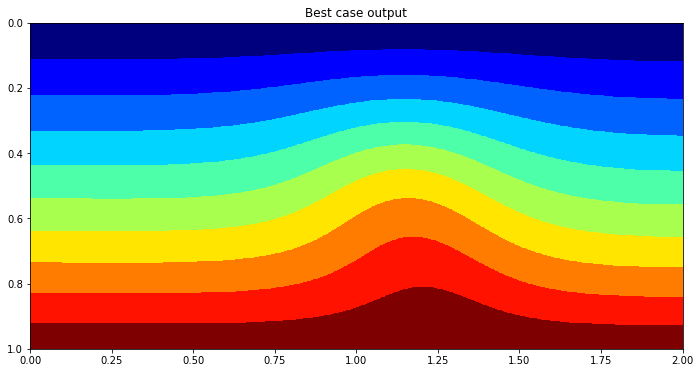

<ipython-input-28-0ebbdcc8d438>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


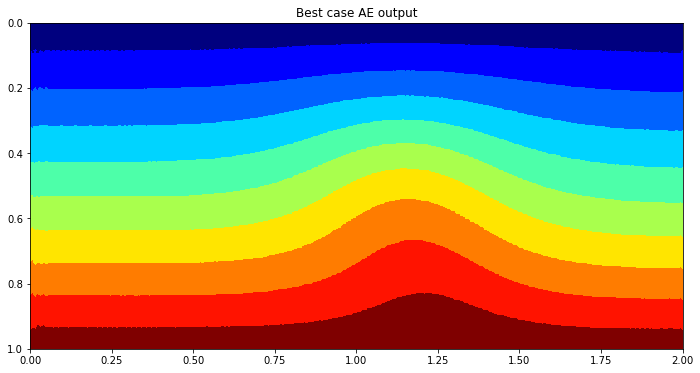

<ipython-input-28-0ebbdcc8d438>:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


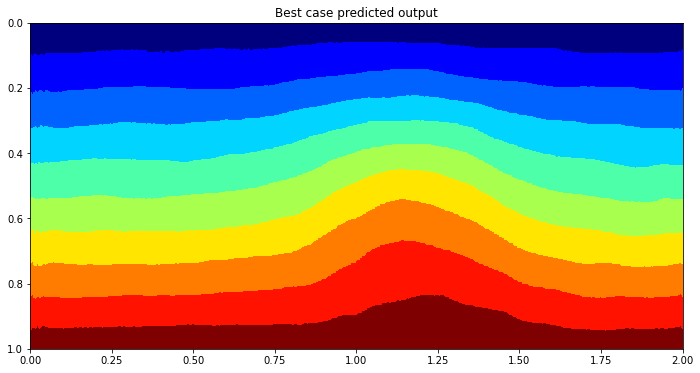

<ipython-input-28-0ebbdcc8d438>:143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


Worst model has a error of  0.00011083215213147923


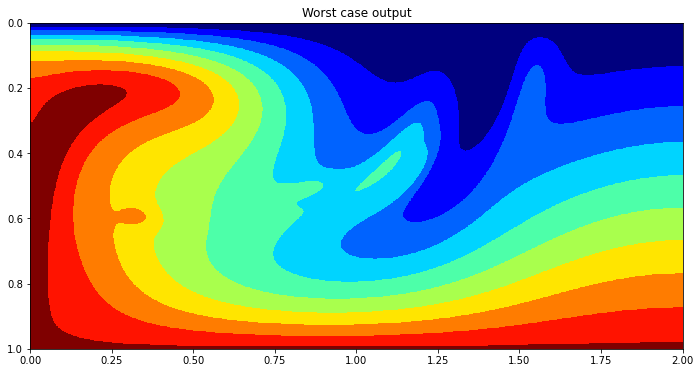

<ipython-input-28-0ebbdcc8d438>:159: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


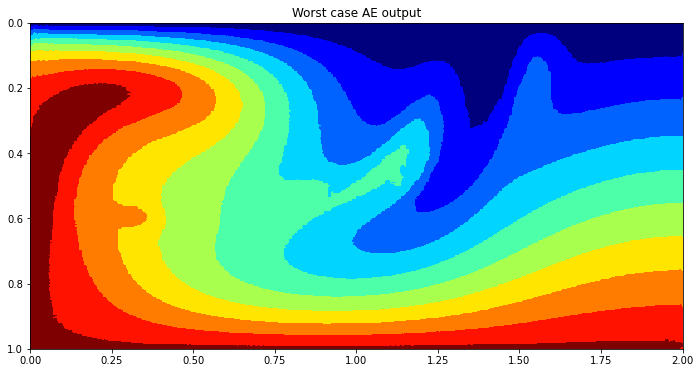

<ipython-input-28-0ebbdcc8d438>:175: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


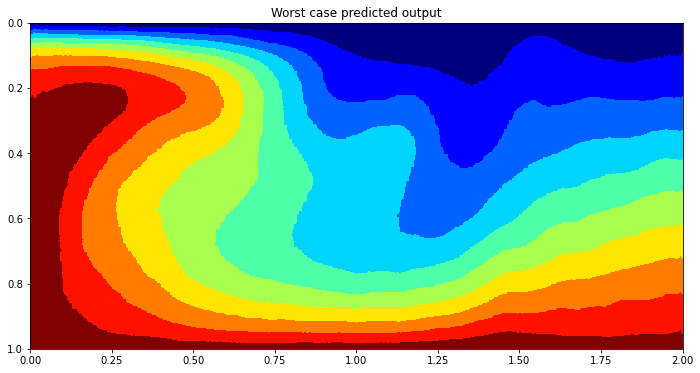

In [29]:
test(model, encoder, decoder, test_loader, device)